In [1]:
import numpy as np
import matplotlib.pyplot as plt
#Latex font
import matplotlib as mpl
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=16)

In [2]:
ms = 1.12                   # stellar mass of 51 Peg (M sun)
ms_error = 0.06             # error in stellar mass (M sun)
fname = "51Pegb.txt"        #open data file and read
data = np.genfromtxt(fname,skip_header=21,autostrip=True)
jd = data[:,0]              # Julian date (day)
rv = data[:,1]              # radial velocity (m/s)
er = data[:,2]              # error in radial velocity (m/s)

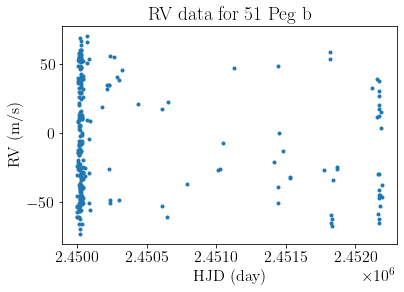

In [3]:
plt.plot(jd,rv,'.')
plt.title('RV data for 51 Peg b')
plt.xlabel('HJD (day)')
plt.ylabel('RV (m/s)')
plt.show()

In [4]:
#compute Lomb-Scargle periodogram from data
from scipy import signal
from astropy.time import Time
from astropy.timeseries import LombScargle
frequency,power = LombScargle(jd,rv,er).autopower()

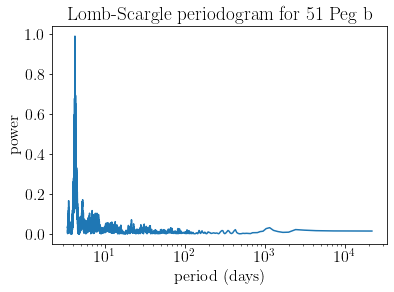

In [5]:
plt.semilogx(1/frequency,power)
plt.title('Lomb-Scargle periodogram for 51 Peg b')
plt.xlabel('period (days)')
plt.ylabel('power')
plt.show()

In [6]:
# find period of strongest signal
period = 1/frequency[np.argmax(power)]
print("The fit period is %10.5f days" % period)

The fit period is    4.23107 days


In [7]:
# calculate model fit based on period of strongest signal
tfit = np.linspace(0,period,1000)
rvfit = LombScargle(jd,rv,er).model(tfit,1/period)

In [8]:
# compute the semi-amplitude K from the model fit
K = 0.5*(np.max(rvfit)-np.min(rvfit))
print("The fit semi-amplitude is %10.5f m/s" % K)

The fit semi-amplitude is   55.60534 m/s


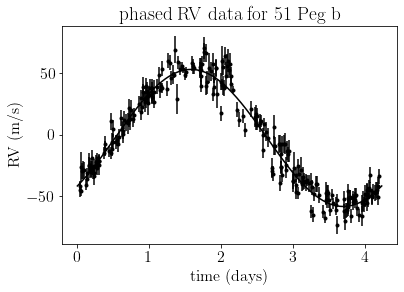

In [9]:
# phase the data and plot it with the fit
phase = jd % period
fig,ax = plt.subplots()
ax.errorbar(phase,rv,er,fmt='.k')
ax.plot(tfit,rvfit,'-k')
plt.title('phased RV data for 51 Peg b')
plt.xlabel('time (days)')
plt.ylabel('RV (m/s)')
plt.show()

In [10]:
#I set my guesses for the orbital parameters 
vr0 = -2.65528     #m/s
K = 55.60534        #m/s
P = 4.23107         #days
e = 0               #No-unit
w = 0           #No-unit
tau = 2450068.67    #days
t = jd
v_rt = rv
sigma = er
for i in range (len(t)):
#    print(i, t[i])
    theta = 2*np.pi*(t[i] - tau)/P
#    print(theta)
    v_rfit = vr0 + K*(np.cos(theta + w) + e*np.cos(w))
#    chi_sqt = np.sum((v_rt - v_rfit)/sigma)**2
#print(chi_sqt)

In [11]:
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

In [12]:
def keplerian_fit(t,K,P,e,w,tau,vr0):
        e_anomaly = solve_kepler((t-tau)*2*np.pi/P,e)
        theta = 2*np.arctan2(np.sqrt(1.+e)*np.sin(0.5*e_anomaly),
                             np.sqrt(1.-e)*np.cos(0.5*e_anomaly))
        return K*(np.cos(theta+w)+e*np.cos(w))+vr0

In [13]:
def solve_kepler(M,e):
    eanom = np.zeros(M.shape)
    for i,mi in enumerate(M):
        # do iterative root solve with e=0 giving E=M as guess
        tmp,=fsolve(lambda E: E-e*np.sin(E)-mi,mi)
        eanom[i] = tmp
    return eanom

In [14]:
guess = (K,P,e,w,tau,vr0)

In [15]:
popt,pcov = curve_fit(keplerian_fit,jd,rv,sigma=er,absolute_sigma=True,p0=guess)

In [16]:
(K,P,e,w,tau,vr0) = popt

In [17]:
rvfit = keplerian_fit(jd,K,P,e,w,tau,vr0)

In [18]:
chisq = np.sum(((rv-rvfit)/er)**2)
print("Chi-squared of least-squares fit is %10.5f" % chisq)

Chi-squared of least-squares fit is  330.59775


In [19]:
if e<0:
    w -= np.pi
    e *= -1
w_deg = w*180/np.pi

In [20]:
print(K,P,e,w,w_deg,tau,vr0)

55.89441347026184 4.230730573660922 0.012529075233743078 0.9798516850656949 56.14136610304624 2450071.292262271 -1.90495809406362


In [21]:
P_yr = P/365.2422               # period in years
a_au = (ms*P_yr**2)**(1./3)     # semi-major axis in au
K_auyr = K*2.1096256684e-4      # K in au/yr

In [22]:
# compute planet mass and convert to Jupiter-mass units
mp = (2*np.pi)**(-1)*K_auyr*np.sqrt(1-e**2)*(ms**2*P_yr)**(1/3)
mp_mjup = mp*1047.59421

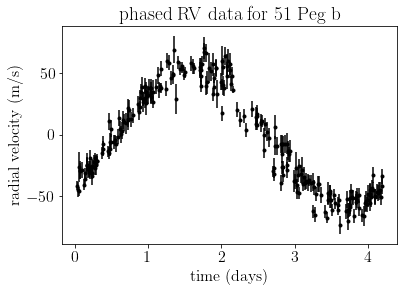

In [23]:
# phase the data and plot it with the fit
phase = jd % period
#print(phase)
fig,ax = plt.subplots()
ax.errorbar(phase,rv,er,fmt='.k')
#ax.plot(tfit,rvfit,'-k')
plt.title('phased RV data for 51 Peg b')
plt.xlabel('time (days)')
plt.ylabel('radial velocity (m/s)')
plt.show()

In [24]:
#(d) The errors may be obtained using
ms = 1.12
ms_error = 0.06

K_error = np.sqrt(pcov[0,0])
P_error = np.sqrt(pcov[1,1])
e_error = np.sqrt(pcov[2,2])
w_error = np.sqrt(pcov[3,3])
tau_error = np.sqrt(pcov[4,4])
a_error = a_au * np.sqrt( (2*P_error/(3*P))**2 + (ms_error/(3*ms))**2 )
mp_error = mp_mjup * np.sqrt( (2*ms_error/(3*ms))**2 + (K_error/K)**2 + (P_error/(3*P))**2 + (e*e_error/np.sqrt(1-e*e))**2 )

In [25]:
print ('K:', K ,'+/-', K_error, 'm/s')
print ('P:', P ,'+/-', P_error, 'days')
print ('e:', e ,'+/-', e_error)
print ('w:', w ,'+/-', w_error, 'deg')
print ('tau:', tau ,'+/-', tau_error, 'days')
print ('a:', a_au ,'+/-', a_error, 'AU')
print ('Mpsin(i):', mp_mjup ,'+/-', mp_error, 'MJ')

K: 55.89441347026184 +/- 1.2716319241829976 m/s
P: 4.230730573660922 +/- 3.67819161887776e-05 days
e: 0.012529075233743078 +/- 0.009790799462504215
w: 0.9798516850656949 +/- 0.7493134003128645 deg
tau: 2450071.292262271 +/- 0.5055233043783012 days
a: 0.05316538381369738 +/- 0.0009493819038243622 AU
Mpsin(i): 0.4797074060332221 +/- 0.020313303170482723 MJ
